In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Styling
plt.style.use('tdrstyle.mplstyle')

In [2]:
from rootpy.io import root_open
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.10/09


In [3]:
infile_r = None  # input file handle

def load_pgun():
  global infile_r
  infile = '../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root'
  #if use_condor:
  #  infile = 'root://cmsio5.rc.ufl.edu//store/user/jiafulow/L1MuonTrigger/P2_10_1_5/SingleMuon_Toy_2GeV/'+infile
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  #tree = TreeChain('ntupler/tree', [infile])
  print('[INFO] Opening file: %s' % infile)

  # Define collection
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  return tree

In [8]:
#maxEvents = 500000
maxEvents = 10000

kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

eta_bins = (1.2, 1.55, 1.7, 1.8, 1.98, 2.15, 2.5)
eta_bins = eta_bins[::-1]
pt_bins = (-0.5 , -0.38, -0.26, -0.15, -0.05, 0.05, 0.15, 0.26, 0.38, 0.5)
nlayers = 12  # 5 (CSC) + 4 (RPC) + 3 (GEM)
superstrip_size = 32

assert(len(eta_bins) == 6+1)
assert(len(pt_bins) == 9+1)

def find_sector(phi):  # phi in radians
  dphi = delta_phi(phi, np.pi/12)  # sector 1 starts at 15 deg
  dphi = int(np.floor(dphi/(np.pi/3)))  # divide by 60 deg
  if dphi < 0:
    sector = 7 + dphi
  else:
    sector = 1 + dphi
  return sector

def find_endcap(eta):
  endcap = +1 if eta >= 0. else -1
  return endcap

def find_endsec(endcap, sector):
  endsec = (sector - 1) if endcap == 1 else (sector - 1 + 6)
  return endsec

def find_pt_bin(pt):
  ipt = np.digitize((pt,), pt_bins[1:])[0]  # skip lowest edge
  ipt = np.clip(ipt, 0, len(pt_bins)-2)
  return ipt

def find_eta_bin(eta):
  ieta = np.digitize((abs(eta),), eta_bins[1:])[0]  # skip lowest edge
  ieta = np.clip(ieta, 0, len(eta_bins)-2)
  return ieta

# Decide EMTF hit layer number
class EMTFLayer(object):
  def __init__(self):
    lut = np.zeros((5,5,5), dtype=np.int32) - 99  # (type, station, ring) -> layer
    lut[1,1,4] = 0  # ME1/1a
    lut[1,1,1] = 0  # ME1/1b
    lut[1,1,2] = 1  # ME1/2
    lut[1,1,3] = 1  # ME1/3
    lut[1,2,1] = 2  # ME2/1
    lut[1,2,2] = 2  # ME2/2
    lut[1,3,1] = 3  # ME3/1
    lut[1,3,2] = 3  # ME3/2
    lut[1,4,1] = 4  # ME4/1
    lut[1,4,2] = 4  # ME4/2
    lut[2,1,2] = 5  # RE1/2
    lut[2,2,2] = 6  # RE2/2
    lut[2,3,1] = 7  # RE3/1
    lut[2,3,2] = 7  # RE3/2
    lut[2,3,3] = 7  # RE3/3
    lut[2,4,1] = 8  # RE4/1
    lut[2,4,2] = 8  # RE4/2
    lut[2,4,3] = 8  # RE4/3
    lut[3,1,1] = 9  # GE1/1
    lut[3,2,1] = 10 # GE2/1
    lut[4,1,1] = 11 # ME0
    self.lut = lut

  def __call__(self, hit):
    index = (hit.type, hit.station, hit.ring)
    entry = self.lut[index]
    return entry

find_emtf_layer = EMTFLayer()

class EMTFZone(object):
  def __init__(self):
    lut = np.zeros((5,5,5,6,2), dtype=np.int32) - 99  # (type, station, ring) -> [zone] x [min_theta,max_theta]
    lut[1,1,4][0] = 4,17   # ME1/1a
    lut[1,1,4][1] = 16,26  # ME1/1a
    lut[1,1,4][2] = 24,37  # ME1/1a
    lut[1,1,4][3] = 34,43  # ME1/1a
    lut[1,1,4][4] = 40,53  # ME1/1a
    lut[1,1,1][0] = 4,17   # ME1/1b
    lut[1,1,1][1] = 16,26  # ME1/1b
    lut[1,1,1][2] = 24,37  # ME1/1b
    lut[1,1,1][3] = 34,43  # ME1/1b
    lut[1,1,1][4] = 40,53  # ME1/1b
    lut[1,1,2][4] = 46,54  # ME1/2
    lut[1,1,2][5] = 52,88  # ME1/2
    lut[1,1,3][4] = 46,54  # ME1/3
    lut[1,1,3][5] = 52,88  # ME1/3
    #
    lut[1,2,1][0] = 4,17   # ME2/1
    lut[1,2,1][1] = 16,25  # ME2/1
    lut[1,2,1][2] = 24,36  # ME2/1
    lut[1,2,1][3] = 34,43  # ME2/1
    lut[1,2,1][4] = 40,49  # ME2/1
    lut[1,2,2][5] = 53,88  # ME2/2
    #
    lut[1,3,1][0] = 4,17   # ME3/1
    lut[1,3,1][1] = 16,25  # ME3/1
    lut[1,3,1][2] = 24,36  # ME3/1
    lut[1,3,1][3] = 34,40  # ME3/1
    lut[1,3,2][4] = 44,54  # ME3/2
    lut[1,3,2][5] = 52,88  # ME3/2
    #
    lut[1,4,1][0] = 4,17   # ME4/1
    lut[1,4,1][1] = 16,25  # ME4/1
    lut[1,4,1][2] = 24,35  # ME4/1
    lut[1,4,2][3] = 38,43  # ME4/2
    lut[1,4,2][4] = 41,54  # ME4/2
    lut[1,4,2][5] = 52,88  # ME4/2
    #
    lut[2,1,2][5] = 52,84  # RE1/2
    lut[2,2,2][5] = 56,76  # RE2/2
    lut[2,3,1][0] = 4,20   # RE3/1
    lut[2,3,1][1] = 20,24  # RE3/1
    lut[2,3,1][2] = 24,32  # RE3/1
    lut[2,3,2][3] = 40,40  # RE3/2
    lut[2,3,2][4] = 40,52  # RE3/2
    lut[2,3,2][5] = 48,84  # RE3/2
    lut[2,3,3][3] = 40,40  # RE3/3
    lut[2,3,3][4] = 40,52  # RE3/3
    lut[2,3,3][5] = 48,84  # RE3/3
    lut[2,4,1][0] = 8,16   # RE4/1
    lut[2,4,1][1] = 16,28  # RE4/1
    lut[2,4,1][2] = 24,28  # RE4/1
    lut[2,4,2][3] = 36,44  # RE4/2
    lut[2,4,2][4] = 44,52  # RE4/2
    lut[2,4,2][5] = 52,84  # RE4/2
    lut[2,4,3][3] = 36,44  # RE4/3
    lut[2,4,3][4] = 44,52  # RE4/3
    lut[2,4,3][5] = 52,84  # RE4/3
    #
    lut[3,1,1][1] = 17,26  # GE1/1
    lut[3,1,1][2] = 24,37  # GE1/1
    lut[3,1,1][3] = 35,45  # GE1/1
    lut[3,1,1][4] = 40,52  # GE1/1
    lut[3,2,1][0] = 7,19   # GE2/1
    lut[3,2,1][1] = 18,24  # GE2/1
    lut[3,2,1][2] = 23,35  # GE2/1
    lut[3,2,1][3] = 34,45  # GE2/1
    lut[3,2,1][4] = 40,46  # GE2/1
    #
    lut[4,1,1][0] = 4,17   # ME0
    lut[4,1,1][1] = 16,23  # ME0
    self.lut = lut
    
  def __call__(self, hit):
    index = (hit.type, hit.station, hit.ring)
    entry = self.lut[index]
    answer = (entry[:,0] <= hit.emtf_theta) & (hit.emtf_theta <= entry[:,1])
    zones = np.nonzero(answer)
    if isinstance(zones, tuple):
      zones = zones[0]
    return zones

find_emtf_zones = EMTFZone()

class EMTFCheckMode(object):
  def __call__(self, mode):
    if hasattr(mode, 'mode'):
      mode = mode.mode
    return mode in (11,13,14,15)

is_good_emtf_mode = EMTFCheckMode()

class EMTFCheckLegit(object):
  def check_bx(self, hit):
    if hit.type == kCSC:
      return hit.bx in (-1,0)
    else:
      return hit.bx == 0

  def check_quality(self, hit):
    if hit.type == kRPC:
      return hit.quality <= 9  # cluster width
    else:
      return True

  def __call__(self, hit):
    return self.check_bx(hit) and self.check_quality(hit)

is_good_emtf_hit = EMTFCheckLegit()

class EMTFZee(object):
  def __init__(self):
    self.lut = np.array([599.0, 696.8, 827.1, 937.5, 1027, 708.7, 790.9, 968.8, 1060, 566.4, 794.8, 539.3], dtype=np.float32)
    assert(self.lut.shape[0] == nlayers)
  
  def __call__(self, hit):
    return self.lut[hit.emtf_layer]

find_emtf_zee = EMTFZee()

class EMTFPhi(object):
  def __init__(self):
    pass
  
  def __call__(self, hit):
    if hit.type == kCSC:
      if hit.station == 1:
        if hit.ring == 1:
          bend_corr_lut = (-1.3861, 1.3692)  # ME1/1b (r,f)
        elif hit.ring == 4:
          bend_corr_lut = (-1.6419, 1.6012)  # ME1/1a (r,f)
        else:
          bend_corr_lut = (-0.9237, 0.8287)  # ME1/2 (r,f)
        bend_corr = bend_corr_lut[int(hit.fr)] * hit.bend
        bend_corr = bend_corr if hit.endcap == 1 else (bend_corr * -1)
        bend_corr = int(round(bend_corr))
        return hit.emtf_phi + bend_corr
      else:
        pass
    else:
      pass
    return hit.emtf_phi

find_emtf_phi = EMTFPhi()


# ______________________________________________________________________________
def analysis(verbose=1):
  tree = load_pgun()
  
  from six.moves import range, zip, map, filter
  from incrementalstats import IncrementalStats
  
  out_part, out_hits = [], []
  
  # Loop over events
  for ievt, evt in enumerate(tree):
    if maxEvents != -1 and ievt == maxEvents:
      break
    
    if verbose and (ievt % 10000 == 0):  print("Processing event: {0}".format(ievt))
    
    # Skip events with very few hits
    if not len(evt.hits) >= 4:
      continue
    
    # Skip events without ME1 hits
    has_ME1 = False
    for ihit, hit in enumerate(evt.hits):
      if hit.type == kCSC and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kME0 and hit.station == 1:
        has_ME1 = True
        break
    if not has_ME1:
      continue
    
    part = evt.particles[0]  # particle gun
    part.invpt = np.true_divide(part.q, part.pt)
    
    # Find the best sector (using csc-only 'mode')
    sector_mode_array = np.zeros((12,), dtype=np.int32)
    sector_hits_array = np.empty((12,), dtype=np.object)
    for ind in np.ndindex(sector_hits_array.shape):
      sector_hits_array[ind] = []
    
    for ihit, hit in enumerate(evt.hits):
      assert(hit.emtf_phi < 5040)  # 84*60
      
      if hit.sim_tp1 == 0 and hit.sim_tp2 == 0:
        endsec = find_endsec(hit.endcap, hit.sector)
        if hit.type == kCSC:
          sector_mode_array[endsec] |= (1<<(4-hit.station))
        elif hit.type == kME0:
          sector_mode_array[endsec] |= (1<<(4-hit.station))
        sector_hits_array[endsec].append(hit)
    
    # Get the best sector
    best_sector = np.argmax(sector_mode_array)
    mode = sector_mode_array[best_sector]
    
    # Skip events without SingleMu modes
    if not is_good_emtf_mode(mode):
      continue
    
    # Get the particle info, road info
    ipt = find_pt_bin(part.invpt)
    ieta = find_eta_bin(part.eta)
    
    # Get the hits
    sector_hits = sector_hits_array[best_sector]
    sector_hits = filter(is_good_emtf_hit, sector_hits)
    
    amap = {}  # zone -> hits
    
    # Loop over sector hits
    for ihit, hit in enumerate(sector_hits):
      hit.emtf_layer = find_emtf_layer(hit)
      assert(hit.emtf_layer != -99)
      
      hit.old_emtf_phi = hit.emtf_phi
      hit.emtf_zee = find_emtf_zee(hit)
      hit.emtf_phi = find_emtf_phi(hit)
      
      zones = find_emtf_zones(hit)
      for z in zones:
        amap.setdefault(np.asscalar(z), []).append(hit)
      continue  # end loop over sector_hits
    
    # Loop over map of zone -> hits
    ievt_part = []
    ievt_hits = []
    
    for k, v in amap.iteritems():
      zone = k
      hits = v
      
      mode = 0  # csc-only 'mode'
      for ihit, hit in enumerate(hits):
        if hit.type == kCSC:
          mode |= (1<<(4-hit.station))
        elif hit.type == kME0:
          mode |= (1<<(4-hit.station))
      
      if not is_good_emtf_mode(mode):
        continue
      
      # Output
      hits_array = np.zeros((50,4), dtype=np.int32) - 99  # output up to 50 hits
      for ihit, hit in enumerate(hits):
        if ihit == 50:
          break
        hits_array[ihit] = (hit.emtf_layer, hit.emtf_phi, hit.old_emtf_phi, hit.emtf_zee)
        
      ievt_part.append((ipt, ieta, zone, mode))
      ievt_hits.append(hits_array)
      continue  # end loop over map of zone -> hits
    
    # Verbose
    if ievt < 20:
      ievt_nhits = [(x[:,0] != -99).sum() for x in ievt_hits]
      print ievt, part.pt, ievt_part, ievt_nhits
      
    out_part += ievt_part
    out_hits += ievt_hits
    continue  # end loop over events

  if verbose: print "DONE"
  return np.asarray(out_part), np.asarray(out_hits)

In [13]:
%%time

# Run analysis
out_part, out_hits = analysis()

[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Processing event: 0
0 2.2441008091 [(0, 1, 1, 14)] [7]
2 2.83313345909 [(7, 0, 0, 14)] [8]
4 6.14469432831 [(2, 5, 5, 15)] [9]
5 5.51849126816 [(6, 3, 3, 15)] [9]
6 2.62028098106 [(8, 1, 1, 11)] [8]
7 6.84316205978 [(3, 1, 1, 15)] [7]
8 2.37840628624 [(8, 1, 1, 15)] [11]
9 2.898209095 [(1, 0, 0, 14)] [8]
10 2.72461438179 [(7, 0, 0, 15)] [8]
11 3.73449015617 [(7, 2, 2, 15)] [9]
12 52.140007019 [(4, 0, 0, 15)] [8]
14 8.361577034 [(3, 5, 5, 15)] [6]
15 7.21895551682 [(3, 3, 3, 15)] [10]
16 25.9081859589 [(4, 4, 3, 13), (4, 4, 4, 13)] [8, 9]
17 2.27322983742 [(0, 0, 0, 13), (0, 0, 1, 13)] [7, 9]
18 16.2746582031 [(5, 2, 2, 13)] [8]
19 10.1214160919 [(5, 3, 3, 13), (5, 3, 4, 13)] [7, 7]
DONE
CPU times: user 37.5 s, sys: 6.1 s, total: 43.6 s
Wall time: 40.8 s


In [14]:
print out_part.shape, out_hits.shape

(8086, 4) (8086, 50, 4)


In [25]:
hits_z = []
hits_phi = []

for part, hits in zip(out_part, out_hits):
  (ipt, ieta, zone, mode) = part
  hits = hits[hits[:,0] != -99]
  
  if ipt == 4 and ieta == 1 and zone == 1 and mode == 15:
    key_phi = None
    for hit in hits:
      (emtf_layer, emtf_phi, old_emtf_phi, emtf_zee) = hit
      if emtf_layer == 2:
        key_phi = emtf_phi
        break
    
    if key_phi is not None:
      for hit in hits:
        (emtf_layer, emtf_phi, old_emtf_phi, emtf_zee) = hit
        hits_z.append(emtf_zee)
        hits_phi.append(emtf_phi - key_phi)

In [41]:
hits_z = np.asarray(hits_z)
hits_phi = np.asarray(hits_phi)
print hits_z.shape, hits_phi.shape

(1119,) (1119,)


In [97]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-4, 1e2))
alpha = 0.1
gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=10)

gp.fit(np.atleast_2d(hits_z).T, hits_phi)
print kernel.get_params()
print gp.kernel_.get_params()

{'k1__constant_value': 1.0, 'k2__length_scale': 1.0, 'k2': RBF(length_scale=1), 'k1': 1**2, 'k1__constant_value_bounds': (0.001, 1000.0), 'k2__length_scale_bounds': (0.0001, 100.0)}
{'k1__constant_value': 53.10450529659442, 'k2__length_scale': 3.6960713958140246, 'k2': RBF(length_scale=3.7), 'k1': 7.29**2, 'k1__constant_value_bounds': (0.001, 1000.0), 'k2__length_scale_bounds': (0.0001, 100.0)}


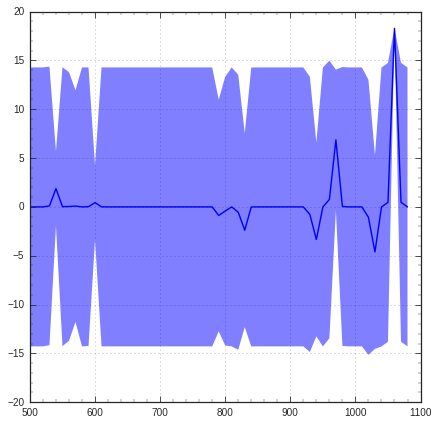

In [98]:
lins_z = np.linspace(500,1080,num=59)
lins_phi, sigma = gp.predict(np.atleast_2d(lins_z).T, return_std=True)

fig, ax = plt.subplots(figsize=(7,7))
#ax.hist2d(hits_z, hits_phi, bins=(58,1024), range=((500,1080),(-512,512)))
ax.plot(lins_z, lins_phi)
ax.fill(np.concatenate([lins_z, lins_z[::-1]]), 
        np.concatenate([lins_phi - 1.9600 * sigma, (lins_phi + 1.9600 * sigma)[::-1]]),
        alpha=.5, fc='b', ec='None', label='95% confidence interval')
#ax.set_xlim(0,1200)
#ax.set_ylim(0,np.pi/4)
plt.show()

In [99]:
hits_phi_test = hits_phi[(598<hits_z) & (hits_z<600)]
print np.percentile(hits_phi_test, [5,95])
print lins_phi[lins_z==600], 1.96*sigma[lins_z==600]

[-46.6  61.2] [ -32   28   35   70   20  -43  -22   12 -122   16   28   13   25  -35
  -23  -20  -20  -15   12   16  -22   -5   85   59   26 -151  -11  -45
   45   45 -278   -8   10  -16  -18   11   45   23  -18  -18    6    5
   29   11  -36  -18  -13  -37   26   50  108  -20  -24   -7  -29    8
   -5  -81  -67   39   27   35   -2  -19   -6   21   20  -17  -24  -17
   11   -7  -20   13   23   26  -30   -1  -11    1    8   28   10   11
  -11  -53   83   17   -5  -12   -9  -22   37  -13   13   -5    8  -15
   15  -14  -25   54  -15   -1   19   -7   23   10   -8   86    1   -1
  -30  -21  168   28   31]


[0.43670437] [3.7951431]


In [101]:
hits_z = []
hits_phi = []

for part, hits in zip(out_part, out_hits):
  (ipt, ieta, zone, mode) = part
  hits = hits[hits[:,0] != -99]
  
  if ipt == 2 and ieta == 1 and zone == 1 and mode == 15:
    key_phi = None
    for hit in hits:
      (emtf_layer, emtf_phi, old_emtf_phi, emtf_zee) = hit
      if emtf_layer == 2:
        key_phi = emtf_phi
        break
    
    if key_phi is not None:
      for hit in hits:
        (emtf_layer, emtf_phi, old_emtf_phi, emtf_zee) = hit
        hits_z.append(emtf_zee)
        hits_phi.append(emtf_phi - key_phi)

In [102]:
hits_z = np.asarray(hits_z)
hits_phi = np.asarray(hits_phi)
print hits_z.shape, hits_phi.shape

(1168,) (1168,)


In [133]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-4, 1e3))
alpha = 10**2
gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=10)

gp.fit(np.atleast_2d(hits_z).T, hits_phi)
print kernel.get_params()
print gp.kernel_.get_params()

{'k1__constant_value': 1.0, 'k2__length_scale': 1.0, 'k2': RBF(length_scale=1), 'k1': 1**2, 'k1__constant_value_bounds': (0.001, 1000.0), 'k2__length_scale_bounds': (0.0001, 1000.0)}
{'k1__constant_value': 999.9999999999998, 'k2__length_scale': 70.10575715128252, 'k2': RBF(length_scale=70.1), 'k1': 31.6**2, 'k1__constant_value_bounds': (0.001, 1000.0), 'k2__length_scale_bounds': (0.0001, 1000.0)}


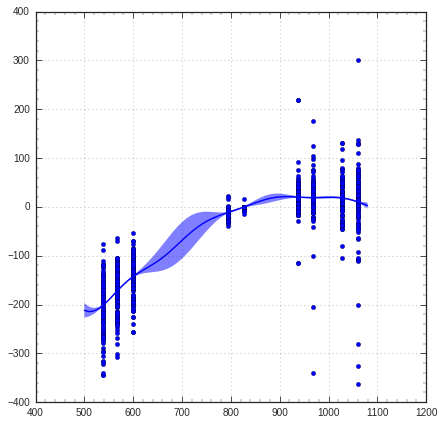

In [134]:
lins_z = np.linspace(500,1080,num=59)
lins_phi, sigma = gp.predict(np.atleast_2d(lins_z).T, return_std=True)

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(hits_z, hits_phi)
#ax.hist2d(hits_z, hits_phi, bins=(58,1024), range=((500,1080),(-512,512)))
ax.plot(lins_z, lins_phi)
ax.fill(np.concatenate([lins_z, lins_z[::-1]]), 
        np.concatenate([lins_phi - 1.9600 * sigma, (lins_phi + 1.9600 * sigma)[::-1]]),
        alpha=.5, fc='b', ec='None', label='95% confidence interval')
#ax.set_xlim(0,1200)
#ax.set_ylim(0,np.pi/4)
plt.show()

In [135]:
hits_phi_test = hits_phi[(598<hits_z) & (hits_z<600)]
print np.percentile(hits_phi_test, [5,50,95]), np.mean(hits_phi_test), np.std(hits_phi_test)
print lins_phi[lins_z==600], 1.96*sigma[lins_z==600]

[-214. -135.  -86.] -143.55833333333334 41.48851162939233
[-142.44829332] [1.8556315]


In [145]:
print X.shape

(2000, 1)
